## 데이터 로드

In [68]:
import pandas as pd

MOVIE_DATA_PATH = "data/movies_refined.csv"
RATING_DATA_PATH = "data/ratings_refined.csv"
TAG_DATA_PATH = "data/tags.csv"

movies_df = pd.read_csv(MOVIE_DATA_PATH)
ratings_df = pd.read_csv(RATING_DATA_PATH)
tags_df = pd.read_csv(TAG_DATA_PATH)

## EDA for ratings



In [48]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

1) 평점 분포 확인

In [49]:
print("=== rating 컬럼 기본 통계 ===")
ratings_df["rating"].describe()

=== rating 컬럼 기본 통계 ===


count    100785.000000
mean          3.501573
std           1.042456
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [50]:
print("\n=== rating 값별 개수 (오름차순) ===")
ratings_df["rating"].value_counts().sort_index()


=== rating 값별 개수 (오름차순) ===


rating
0.5     1368
1.0     2809
1.5     1791
2.0     7548
2.5     5544
3.0    20041
3.5    13128
4.0    26809
4.5     8543
5.0    13204
Name: count, dtype: int64

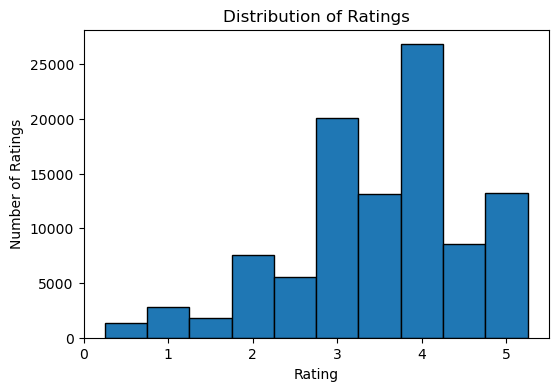

In [51]:
# 히스토그램
plt.figure(figsize=(6, 4))
bins = np.arange(ratings_df["rating"].min() - 0.25,
                 ratings_df["rating"].max() + 0.5,
                 0.5)
plt.hist(ratings_df["rating"], bins=bins, edgecolor="black")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")
plt.show()

2) 유저/영화별 rating 개수 분포



In [52]:
# 한 유저가 남긴 rating 개수
user_rating_counts = ratings_df.groupby("user_id")["rating"].size()

# 한 영화가 받은 rating 개수
movie_rating_counts = ratings_df.groupby("movie_id")["rating"].size()

print("\n=== 한 유저가 남긴 rating 개수 분포 ===")
print(user_rating_counts.describe())

print("\n=== 한 영화가 받은 rating 개수 분포 ===")
print(movie_rating_counts.describe())


=== 한 유저가 남긴 rating 개수 분포 ===
count     610.000000
mean      165.221311
std       269.294838
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2696.000000
Name: rating, dtype: float64

=== 한 영화가 받은 rating 개수 분포 ===
count    9685.000000
mean       10.406298
std        22.438590
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: rating, dtype: float64


In [53]:
print("\n=== rating을 많이 남긴 유저 Top 5 ===")
display(
    user_rating_counts
    .sort_values(ascending=False)
    .head()
    .to_frame(name="n_ratings")
)

print("\n=== 많이 평가된 영화 Top 5 (movie_id 기준) ===")
display(
    movie_rating_counts
    .sort_values(ascending=False)
    .head()
    .to_frame(name="n_ratings")
)


=== rating을 많이 남긴 유저 Top 5 ===


,n_ratings
user_id,
414,2696
599,2474
474,2108
448,1862
274,1346



=== 많이 평가된 영화 Top 5 (movie_id 기준) ===


,n_ratings
movie_id,
356,329
318,317
296,307
593,279
2571,278


3) 중복 여부 확인



In [54]:
dup_mask = ratings_df.duplicated(subset=["user_id", "movie_id"])
dup_count = int(dup_mask.sum())

print(f"\n(user_id, movie_id) 기준 중복 row 수: {dup_count}")
print(f"전체 대비 중복 비율: {dup_count / len(ratings_df):.4%}")


(user_id, movie_id) 기준 중복 row 수: 0
전체 대비 중복 비율: 0.0000%


4) year 변환



In [55]:
# rating이 언제 찍힌 건지 보기 위한 컬럼
ratings_df["rated_at"] = pd.to_datetime(ratings_df["timestamp"], unit="s")
ratings_df["rating_year"] = ratings_df["rated_at"].dt.year

print("\n=== rated_at / rating_year 예시 ===")
display(
    ratings_df[
        ["user_id", "movie_id", "rating", "timestamp", "rated_at", "rating_year"]
    ].head()
)


=== rated_at / rating_year 예시 ===


,user_id,movie_id,rating,timestamp,rated_at,rating_year
0,429,420,2.0,828124615,1996-03-29 18:36:55,1996
1,429,222,4.0,828124615,1996-03-29 18:36:55,1996
2,429,343,3.0,828124615,1996-03-29 18:36:55,1996
3,429,349,3.0,828124615,1996-03-29 18:36:55,1996
4,429,351,4.0,828124615,1996-03-29 18:36:55,1996


In [56]:
# 연도별 rating 개수
year_counts = ratings_df["rating_year"].value_counts().sort_index()

print("\n=== 연도별 rating 개수 ===")
year_counts


=== 연도별 rating 개수 ===


rating_year
1996     6040
1997     1916
1998      507
1999     2439
2000    10061
2001     3922
2002     3478
2003     4014
2004     3279
2005     5813
2006     4058
2007     7114
2008     4351
2009     4157
2010     2301
2011     1690
2012     4656
2013     1664
2014     1439
2015     6614
2016     6698
2017     8191
2018     6383
Name: count, dtype: int64

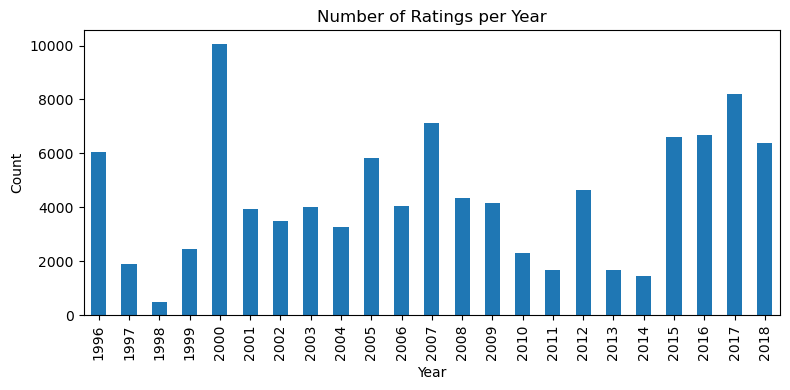

In [57]:
plt.figure(figsize=(8, 4))
year_counts.plot(kind="bar")
plt.title("Number of Ratings per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## 평점 편향 보정
어떤 유저는 항상 5점(관대) / 어떤 유저는 항상 3점(짜다)

그래서 “유저 평균” 기준으로 봤을 때

항상 5점만 주는 유저의 5점 → 평균과 거의 차이 없음 → 특별히 좋아한 건 아님

보통 3점만 주다가 어떤 영화에만 5점 준 유저 → 평균보다 +2 → 진짜 좋아한 영화



In [58]:
import numpy as np
import pandas as pd

# 1) 유저별 평균 평점 구하기
user_mean = (
    ratings_df
    .groupby("user_id")["rating"]
    .mean()
    .rename("user_mean_rating")
)

# 2) 원래 ratings_df에 유저별 평균 붙이기
ratings_df = ratings_df.merge(user_mean, on="user_id", how="left")

# 3) "평균에서 얼마나 벗어났는지"를 나타내는 컬럼 생성
#    → 이 값을 가지고 벡터화/유사도/추천에 사용할 것
ratings_df["rating_centered"] = ratings_df["rating"] - ratings_df["user_mean_rating"]

print(ratings_df[["user_id", "movie_id", "rating", "user_mean_rating", "rating_centered"]].head())



   user_id  movie_id  rating  user_mean_rating  rating_centered
0      429       420     2.0          3.982759        -1.982759
1      429       222     4.0          3.982759         0.017241
2      429       343     3.0          3.982759        -0.982759
3      429       349     3.0          3.982759        -0.982759
4      429       351     4.0          3.982759         0.017241


## 벡터화: item-user 행렬



In [59]:
# user_id × movie_id 행렬 (값은 rating_centered)
#  - index: user_id
#  - columns: movie_id
#  - 값: 각 유저의 "평균 대비 편차" 평점
user_item_matrix = ratings_df.pivot_table(
    index="user_id",
    columns="movie_id",
    values="rating_centered",
    fill_value=0.0,  # 안 본 영화는 0 (평균적인 선호 없음으로 처리)
)

print("user_item_matrix shape:", user_item_matrix.shape)

# item-user 행렬로 전치
#  - index: movie_id
#  - columns: user_id
item_user_matrix = user_item_matrix.T

print("item_user_matrix shape:", item_user_matrix.shape)


user_item_matrix shape: (610, 9685)
item_user_matrix shape: (9685, 610)


## 아이템 간 유사도(dot product) 계산
dot product 기반 item similarity:

벡터끼리 내적(dot)을 하면

같은 유저들에게 비슷한 식으로 “평균보다 좋았던 영화들”이면 값이 커지고

한쪽은 평균보다 좋고, 한쪽은 평균보다 싫었던 영화끼리는 값이 작거나 음수가 됨.



In [60]:
# numpy 배열로 뽑기
item_ids = item_user_matrix.index.to_numpy()     # 영화 ID 순서
user_ids = item_user_matrix.columns.to_numpy()  # 유저 ID 순서

item_matrix = item_user_matrix.to_numpy()       # shape: (n_items, n_users)

# item-item 유사도 행렬 (dot product)
#   sim[i, j] = 벡터 i와 j의 내적
item_sim_matrix = np.dot(item_matrix, item_matrix.T)

# DataFrame으로 래핑 (index/columns = movie_id)
item_sim_df = pd.DataFrame(
    item_sim_matrix,
    index=item_ids,
    columns=item_ids,
)

print("item_sim_df shape:", item_sim_df.shape)
item_sim_df.iloc[:5, :5]

item_sim_df shape: (9685, 9685)


,1,2,3,4,5
1,152.777324,5.849204,4.101075,-1.459290,-11.276642
2,5.849204,59.337005,2.806498,-2.686628,4.097338
3,4.101075,2.806498,41.923204,-0.743590,4.221411
4,-1.459290,-2.686628,-0.743590,10.649285,0.464744
5,-11.276642,4.097338,4.221411,0.464744,42.176181


## 추천함수 구현



In [61]:
from IPython.display import display
import numpy as np
import pandas as pd

def recommend_for_user(
    target_user_id: int,
    top_n: int = 10,
):
    """
    user bias 보정된 rating_centered + item-based dot-product 유사도를 사용해서
    target_user_id에게 영화를 추천하고,
    그 유저가 이미 평가한 영화 리스트도 같이 반환/출력.
    """
    # 0) 유저 존재 여부 체크
    if target_user_id not in user_item_matrix.index:
        print(f"[WARN] user_id {target_user_id} 는 user_item_matrix에 없습니다.")
        return (
            pd.DataFrame(columns=["movie_id", "score", "title", "genres"]),
            pd.DataFrame(columns=["movie_id", "rating", "rating_centered", "title", "genres"]),
        )
    
    # 1) 해당 유저의 rating_centered 벡터 (index=movie_id)
    user_centered_ratings = user_item_matrix.loc[target_user_id]
    
    # 2) numpy 벡터로 변환 (영화 순서 = item_ids 순서와 맞추기)
    user_vector = user_centered_ratings.reindex(item_ids, fill_value=0.0).to_numpy()
    
    # 3) dot-product 기반 예측 점수 계산
    scores = np.dot(user_vector, item_sim_matrix)  # shape: (n_items,)
    
    # 4) 이미 본 영화(평가한 영화)는 추천에서 제외
    already_rated_mask = user_centered_ratings.reindex(
        item_ids,
        fill_value=0.0,
    ).to_numpy() != 0.0
    
    scores_filtered = scores.copy()
    scores_filtered[already_rated_mask] = -np.inf  # 본 영화는 점수를 -inf로
    
    # 5) 유효한 후보(안 본 영화) 개수
    n_candidates = np.isfinite(scores_filtered).sum()
    if n_candidates == 0:
        print("[INFO] 추천할 수 있는 영화가 없습니다. (이 유저는 모든 영화를 평가했을 수 있음)")
        rec_df = pd.DataFrame(columns=["movie_id", "score", "title", "genres"])
    else:
        n_top = min(top_n, n_candidates)
        top_indices = np.argpartition(-scores_filtered, n_top - 1)[:n_top]
        top_indices = top_indices[np.argsort(-scores_filtered[top_indices])]  # 점수 기준 정렬
        
        top_movie_ids = item_ids[top_indices]
        top_scores = scores_filtered[top_indices]
        
        rec_df = (
            pd.DataFrame({"movie_id": top_movie_ids, "score": top_scores})
            .merge(movies_df, on="movie_id", how="left")
            .reset_index(drop=True)
        )
    
    # 6) 이 유저가 이미 본(평가한) 영화 리스트 만들기
    user_seen_df = (
        ratings_df[ratings_df["user_id"] == target_user_id]
        [["movie_id", "rating", "rating_centered"]]
        .merge(movies_df, on="movie_id", how="left")
        .sort_values("rating_centered", ascending=False)  # 평균 대비 얼마나 좋아했는지 기준으로 정렬
        .reset_index(drop=True)
    )
    
    # 7) 보기 좋게 출력
    print(f"=== user_id {target_user_id} 가 이미 평가한 영화들 (상위 20개만 표시) ===")
    display(user_seen_df.head(20))
    
    print(f"\n=== user_id {target_user_id} 에게 추천하는 영화 Top {top_n} ===")
    display(rec_df)
    
    # 8) 두 개 다 리턴 (필요하면 변수에 따로 담아서 쓸 수 있음)
    return rec_df, user_seen_df


In [67]:
rec_df, seen_df = recommend_for_user(1, top_n=10)


=== user_id 1 가 이미 평가한 영화들 (상위 20개만 표시) ===


,movie_id,rating,rating_centered,title,year,genres
0,1049,5.0,0.633621,"Ghost and the Darkness, The (1996)",1996,Action Adventure
1,3441,5.0,0.633621,Red Dawn (1984),1984,Action Drama War
2,1089,5.0,0.633621,Reservoir Dogs (1992),1992,Crime Mystery Thriller
3,1617,5.0,0.633621,L.A. Confidential (1997),1997,Crime Film-Noir Mystery Thriller
4,1275,5.0,0.633621,Highlander (1986),1986,Action Adventure Fantasy
5,1573,5.0,0.633621,Face/Off (1997),1997,Action Crime Drama Thriller
6,2580,5.0,0.633621,Go (1999),1999,Comedy Crime
7,1804,5.0,0.633621,"Newton Boys, The (1998)",1998,Crime Drama
8,2991,5.0,0.633621,Live and Let Die (1973),1973,Action Adventure Thriller
9,2529,5.0,0.633621,Planet of the Apes (1968),1968,Action Drama Sci-Fi



=== user_id 1 에게 추천하는 영화 Top 10 ===


,movie_id,score,title,year,genres
0,858,1189.418810,"Godfather, The (1972)",1972,Crime Drama
1,318,1152.298612,"Shawshank Redemption, The (1994)",1994,Crime Drama
2,1221,871.301121,"Godfather: Part II, The (1974)",1974,Crime Drama
3,541,828.386679,Blade Runner (1982),1982,Action Sci-Fi Thriller
4,4993,782.103172,"Lord of the Rings: The Fellowship of the Ring,...",2001,Adventure Fantasy
5,4226,770.789006,Memento (2000),2000,Mystery Thriller
6,7153,739.814871,"Lord of the Rings: The Return of the King, The...",2003,Action Adventure Drama Fantasy
7,924,727.017908,2001: A Space Odyssey (1968),1968,Adventure Drama Sci-Fi
8,589,696.757896,Terminator 2: Judgment Day (1991),1991,Action Sci-Fi
9,750,671.653397,Dr. Strangelove or: How I Learned to Stop Worr...,1964,Comedy War


## RMSE 성능평가

1) Train/Test data set 나누기

In [63]:
import numpy as np
import pandas as pd

# 1) 평점 데이터 섞기
ratings_shuffled = ratings_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# 2) 80% train, 20% test 로 나누기 (비율은 자유)
train_size = int(len(ratings_shuffled) * 0.8)

train_ratings = ratings_shuffled.iloc[:train_size].copy()
test_ratings  = ratings_shuffled.iloc[train_size:].copy()

print("전체 개수:", len(ratings_shuffled))
print("train 개수:", len(train_ratings))
print("test 개수:", len(test_ratings))


전체 개수: 100785
train 개수: 80628
test 개수: 20157


2) Train 기준으로 user bias 보정 + 행렬 만들기

In [64]:
import numpy as np
import pandas as pd

# === 0) RMSE용으로 깨끗한 rating 데이터 만들기 ===
# 기존에 만들었던 user_mean_rating, rating_centered 같은 컬럼이 있다면 제거
base_cols = ["user_id", "movie_id", "rating", "timestamp"]
ratings_base = ratings_df[base_cols].copy()

# === 1) train / test 나누기 ===
ratings_shuffled = ratings_base.sample(frac=1.0, random_state=42).reset_index(drop=True)

train_size = int(len(ratings_shuffled) * 0.8)
train_ratings = ratings_shuffled.iloc[:train_size].copy()
test_ratings  = ratings_shuffled.iloc[train_size:].copy()

print("전체 개수:", len(ratings_shuffled))
print("train 개수:", len(train_ratings))
print("test 개수:", len(test_ratings))

# === 2) train 기준 user bias 보정 ===

# 2-1) train에서 user별 평균 평점 계산
user_mean_train = (
    train_ratings
    .groupby("user_id")["rating"]
    .mean()
    .rename("user_mean_rating")
)

# 2-2) train에 유저 평균 붙이고 rating_centered 생성
train_ratings = train_ratings.merge(user_mean_train, on="user_id", how="left")
train_ratings["rating_centered"] = train_ratings["rating"] - train_ratings["user_mean_rating"]

# 2-3) test에도 user_mean 붙이기
test_ratings = test_ratings.merge(user_mean_train, on="user_id", how="left")

# train에 없는 유저(user_mean_rating=NaN)는 평가 대상에서 제외
test_ratings = test_ratings.dropna(subset=["user_mean_rating"]).copy()

# test도 중심화 값 만들어두면 분석에 좋음 (RMSE 계산에는 rating만 써도 OK)
test_ratings["rating_centered"] = test_ratings["rating"] - test_ratings["user_mean_rating"]

print("\nuser_mean_train 개수:", len(user_mean_train))
print("user_mean이 있는 test_ratings 개수:", len(test_ratings))

# === 3) user × item 행렬 (값 = rating_centered) 만들기 ===
user_item_matrix_train = train_ratings.pivot_table(
    index="user_id",
    columns="movie_id",
    values="rating_centered",
    fill_value=0.0,
)

# item × user 행렬 + item-item 유사도(dot product)
item_user_matrix_train = user_item_matrix_train.T

item_ids_train = item_user_matrix_train.index.to_numpy()
item_matrix_train = item_user_matrix_train.to_numpy()

item_sim_matrix_train = np.dot(item_matrix_train, item_matrix_train.T)

print("\nuser_item_matrix_train.shape:", user_item_matrix_train.shape)
print("item_sim_matrix_train.shape:", item_sim_matrix_train.shape)


전체 개수: 100785
train 개수: 80628
test 개수: 20157

user_mean_train 개수: 610
user_mean이 있는 test_ratings 개수: 20157

user_item_matrix_train.shape: (610, 8923)
item_sim_matrix_train.shape: (8923, 8923)


3) 예측 평점 함수 만들기

In [65]:
def predict_rating_item_based(user_id: int, movie_id: int) -> float:
    """
    train 데이터 기준 user bias 보정 + item-based CF로
    (user_id, movie_id) 평점을 예측하는 함수.
    
    반환값: 예측 평점 (float) 또는 np.nan (예측 불가한 경우)
    """
    # 1) train에 없는 유저/영화면 예측 불가
    if user_id not in user_item_matrix_train.index:
        return np.nan
    if movie_id not in item_ids_train:
        return np.nan
    
    # 2) 해당 유저의 rating_centered 벡터 (index=movie_id)
    user_vector = user_item_matrix_train.loc[user_id]  # Series
    
    # 3) target item의 similarity 벡터 (target item vs 모든 item)
    target_idx = np.where(item_ids_train == movie_id)[0][0]
    sims = item_sim_matrix_train[target_idx]  # shape: (n_items,)
    
    # 4) 유저가 이미 본 영화들만 사용 (rating_centered != 0 인 곳만)
    rated_mask = (user_vector != 0.0).to_numpy()
    sims_rated = sims[rated_mask]
    ratings_centered_rated = user_vector.to_numpy()[rated_mask]
    
    # 유저가 train에서 본 영화가 하나도 없으면 예측 불가
    if len(ratings_centered_rated) == 0:
        return np.nan
    
    # 5) 가중 평균 계산
    denom = np.sum(np.abs(sims_rated))
    if denom == 0:
        return np.nan
    
    pred_centered = np.sum(sims_rated * ratings_centered_rated) / denom
    
    # 6) user 평균을 다시 더해 원래 스케일로 복원
    mu_u = user_mean_train.loc[user_id]
    pred_rating = mu_u + pred_centered
    
    # 7) 평점 범위(0.5~5.0)에 맞게 클리핑 (MovieLens 기준)
    pred_rating = max(0.5, min(5.0, pred_rating))
    
    return float(pred_rating)

4)Test set에서 RMSE 계산

In [66]:
y_true = []
y_pred = []

for row in test_ratings.itertuples():
    u = row.user_id
    i = row.movie_id
    r_real = row.rating
    
    r_pred = predict_rating_item_based(u, i)
    
    # 예측 불가능한 샘플은 스킵
    if np.isnan(r_pred):
        continue
    
    y_true.append(r_real)
    y_pred.append(r_pred)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

print(f"Test RMSE (item-based CF + user bias 보정): {rmse:.4f}")
print(f"RMSE 계산에 사용된 샘플 개수: {len(y_true)} / 전체 test 개수: {len(test_ratings)}")

Test RMSE (item-based CF + user bias 보정): 0.8626
RMSE 계산에 사용된 샘플 개수: 19330 / 전체 test 개수: 20157
